In [ ]:
import torch
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)
from tsai.all import *
import sklearn.metrics as skm
import sys
from sklearn.model_selection import train_test_split
import numpy as np
import random

sys.path.append('../pre_processing_and_recover_network')
import data_preprocessing
my_setup()

In [ ]:
# prepare the data
def split_data_indexes(len_data, train_ratio):
    indexes = list(range(len_data))
    random.shuffle(indexes)
    train_size = int(len_data * train_ratio)
    train_indexes = indexes[:train_size]
    test_indexes = indexes[train_size:]
    return (train_indexes, test_indexes)

swell_data = data_preprocessing.load_data(os.path.join("../pre_processing_and_recover_network/swell_dataset/","swell_dict.npy"))
swell_data = data_preprocessing.swell_prepare_for_10fold(swell_data)
swell_data[:, 1:4] -= 1
x = swell_data[:, 4:]

y_arousal = swell_data[:, 2]
y_arousal = y_arousal.reshape(y_arousal.shape[0],)

y_valence = swell_data[:, 3]
y_valence = y_valence.reshape(y_valence.shape[0],)

y_stress = swell_data[:, 1]
y_stress = y_stress.reshape(y_stress.shape[0],)

print(x.shape)
print(type(x))
print(y_stress.shape)
print(y_valence.shape)
print(y_arousal.shape)


# set X to 3-Dim array
x = np.array(x)
x = np.expand_dims(x, axis=1)
print(x.shape)
filename = 'X_memmap.npy'
X = np.memmap(filename, dtype='float32', mode='w+', shape=x.shape)
X[:] = x[:]
print(X.shape)
print(type(X))

filename = 'Y_arousal_memmap.npy'
Y_arousal = np.memmap(filename, dtype='float32', mode='w+', shape=y_arousal.shape)
Y_arousal[:] = y_arousal[:]

filename = 'Y_valence_memmap.npy'
Y_valence = np.memmap(filename, dtype='float32', mode='w+', shape=y_valence.shape)
Y_valence[:] = y_valence[:]

filename = 'Y_stress_memmap.npy'
Y_stress = np.memmap(filename, dtype='float32', mode='w+', shape=y_stress.shape)
Y_stress[:] = y_stress[:]
print(Y_stress.shape)
print(type(Y_stress))
for i in range(10):
    splits=split_data_indexes(X.shape[0],0.9)
    np.save("./ten_fold/fold_"+str(i),splits)
print(len(splits[0]))
print(len(splits[1]))

**Stress**

In [ ]:
for i in range(10):    
    tfms  = [None, [Categorize()]]
    splits=np.load('./ten_fold/fold_'+str(i)+'.npy',allow_pickle=True)
    splits=(splits[0],splits[1])
    dsets_stress = TSDatasets(X, Y_stress, tfms=tfms, splits=splits, inplace=True)
    bs=128
    dls_stress = TSDataLoaders.from_dsets(dsets_stress.train, dsets_stress.valid, bs=bs, batch_tfms=[TSStandardize()], num_workers=0)
    model_stress = InceptionTime(dls_stress.vars, dls_stress.c)
    learn_stress = Learner(dls_stress, model_stress, metrics=accuracy)
    record=[]
    for s in range(100):
        learn_stress.fit_one_cycle(1,lr_max=1e-3)
        record.append(learn_stress.final_record.items)
    np.save("./ten_fold/stress_"+str(i),record)
    learn_stress.save_all(path='./ten_fold', dls_fname='dls_stress_'+str(i), model_fname='model_stress_'+str(i), learner_fname='learner_stress_'+str(i))
    torch.cuda.empty_cache()
    torch.cuda.memory_summary(device=None, abbreviated=False)


**Arousal**

In [ ]:
for i in range(10):    
    tfms  = [None, [Categorize()]]
    splits=np.load('./ten_fold/fold_'+str(i)+'.npy',allow_pickle=True)
    splits=(splits[0],splits[1])
    dsets_arousal = TSDatasets(X, Y_arousal, tfms=tfms, splits=splits, inplace=True)
    bs=128
    dls_arousal = TSDataLoaders.from_dsets(dsets_arousal.train, dsets_arousal.valid, bs=bs, batch_tfms=[TSStandardize()], num_workers=0)
    model_arousal = InceptionTime(dls_stress.vars, dls_arousal.c)
    learn_arousal = Learner(dls_arousal, model_arousal, metrics=accuracy)
    record=[]
    for s in range(100):
        learn_arousal.fit_one_cycle(1,lr_max=1e-3)
        record.append(learn_arousal.final_record.items)
    np.save("./ten_fold/arousal_"+str(i),record)
    learn_arousal.save_all(path='./ten_fold', dls_fname='dls_arousal_'+str(i), model_fname='model_arousal_'+str(i), learner_fname='learner_arousal_'+str(i))
    torch.cuda.empty_cache()
    torch.cuda.memory_summary(device=None, abbreviated=False)

**Valence**

In [ ]:
for i in range(10):    
    tfms  = [None, [Categorize()]]
    splits=np.load('./ten_fold/fold_'+str(i)+'.npy',allow_pickle=True)
    splits=(splits[0],splits[1])
    dsets_valence = TSDatasets(X, Y_valence, tfms=tfms, splits=splits, inplace=True)
    bs=128
    dls_valence = TSDataLoaders.from_dsets(dsets_valence.train, dsets_valence.valid, bs=bs, batch_tfms=[TSStandardize()], num_workers=0)
    model_valence = InceptionTime(dls_valence.vars, dls_valence.c)
    learn_valence = Learner(dls_valence, model_valence, metrics=accuracy)
    record=[]
    for s in range(100):
        learn_valence.fit_one_cycle(1,lr_max=1e-3)
        record.append(learn_valence.final_record.items)
    np.save("./ten_fold/valence_"+str(i),record)
    learn_valence.save_all(path='./ten_fold', dls_fname='dls_valence_'+str(i), model_fname='model_valence_'+str(i), learner_fname='learner_valence_'+str(i))
    torch.cuda.empty_cache()
    torch.cuda.memory_summary(device=None, abbreviated=False)

**STRESS RESULTS**

[1.01161861 0.98601002 0.47534245]


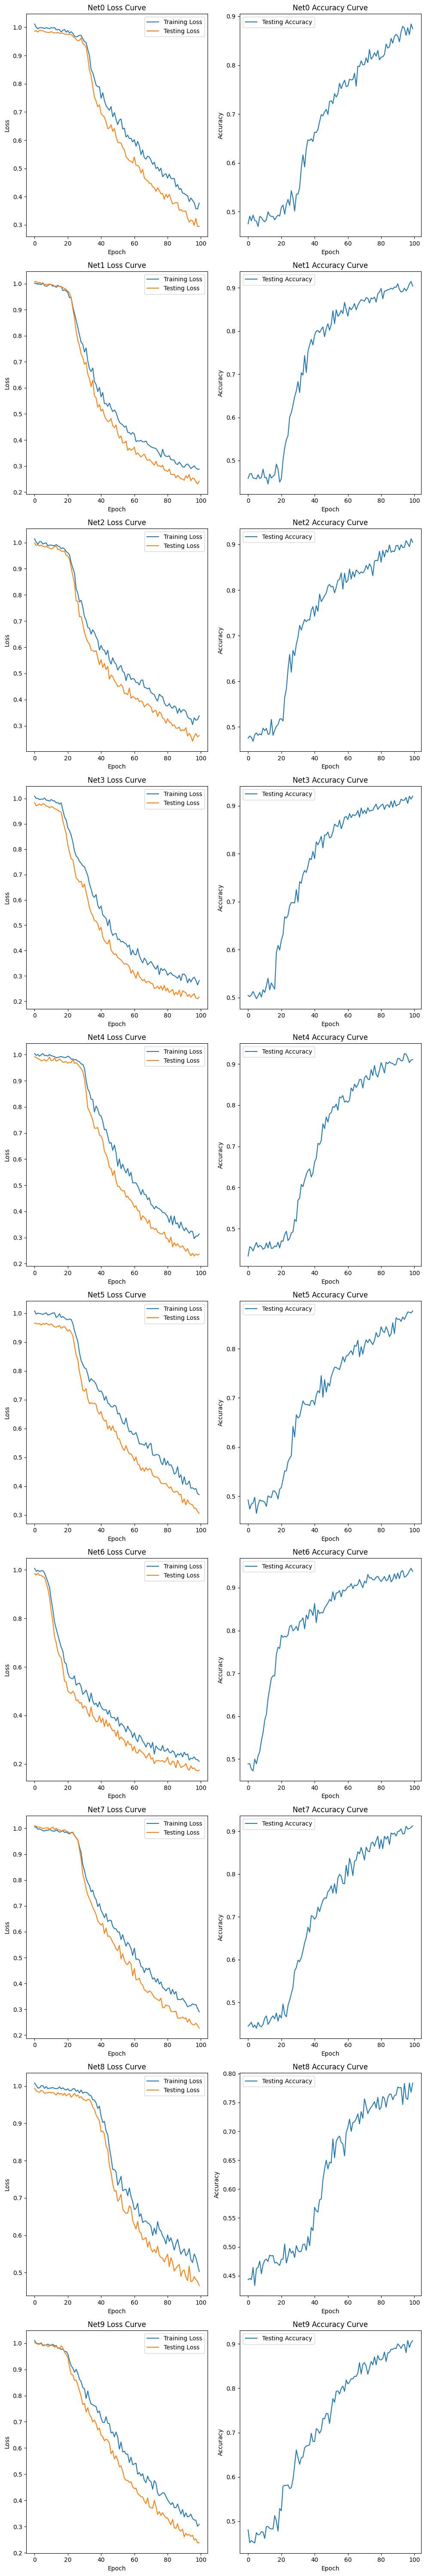

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
loss_train_final=[]
loss_test_final=[]
acc_test_final=[]


# Assuming you have the training and testing loss/accuracy values for each of the 22 networks stored in a dictionary called "results"
fig, axs = plt.subplots(10, 2, figsize=(10, 60))

for f in range(10):
    record=np.load("./ten_fold/stress_"+str(f)+".npy")
    if f==0:
        print(record[0,:])
    train_loss = record[:,0]
    loss_train_final.append(train_loss[99])
    test_loss = record[:,1]
    loss_test_final.append(test_loss[99])
    test_acc = record[:,2]
    acc_test_final.append(test_acc[99])
    # Plot the training and testing loss curves for this network
    axs[f, 0].plot(train_loss, label="Training Loss")
    axs[f, 0].plot(test_loss, label="Testing Loss")
    axs[f, 0].set_title(f"Net{int(f)} Loss Curve")
    axs[f, 0].set_xlabel("Epoch")
    axs[f, 0].set_ylabel("Loss")
    axs[f, 0].legend()
    
    # Plot the training and testing accuracy curves for this network
    axs[f, 1].plot(test_acc, label="Testing Accuracy")
    axs[f, 1].set_title(f"Net{int(f)} Accuracy Curve")
    axs[f, 1].set_xlabel("Epoch")
    axs[f, 1].set_ylabel("Accuracy")
    axs[f, 1].legend()

plt.tight_layout()
plt.show()

The average accuracy of 10 network is  0.8932191729545593
The average MAX of 10 network is  0.9376712441444397
The average MIN of 10 network is  0.783561646938324


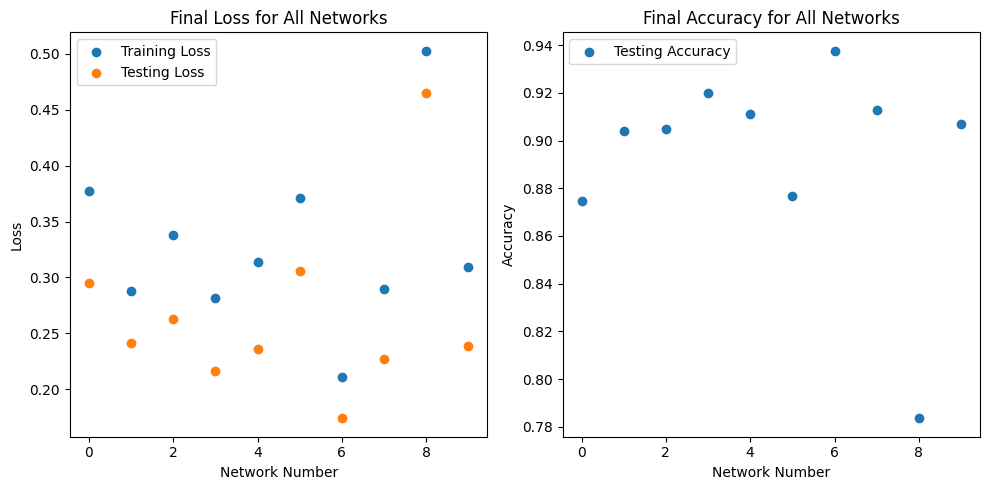

In [22]:
train_loss = loss_train_final
test_loss = loss_test_final
test_acc = acc_test_final
import matplotlib.pyplot as plt

print("The average accuracy of 10 network is ",np.average(test_acc))
print("The average MAX of 10 network is ",np.max(test_acc))
print("The average MIN of 10 network is ",np.min(test_acc))
    
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
x=[0,1,2,3,4,5,6,7,8,9]

# Plot the final training and testing loss for all networks
axs[0].scatter(x, train_loss, label="Training Loss")
axs[0].scatter(x, test_loss, label="Testing Loss")
axs[0].set_title("Final Loss for All Networks")
axs[0].set_xlabel("Network Number")
axs[0].set_ylabel("Loss")
axs[0].legend()

# Plot the final training and testing accuracy for all networks
axs[1].scatter(x, test_acc, label="Testing Accuracy")
axs[1].set_title("Final Accuracy for All Networks")
axs[1].set_xlabel("Network Number")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

**AROUSAL RESULTS**

[1.73259199 1.64883804 0.3280822 ]


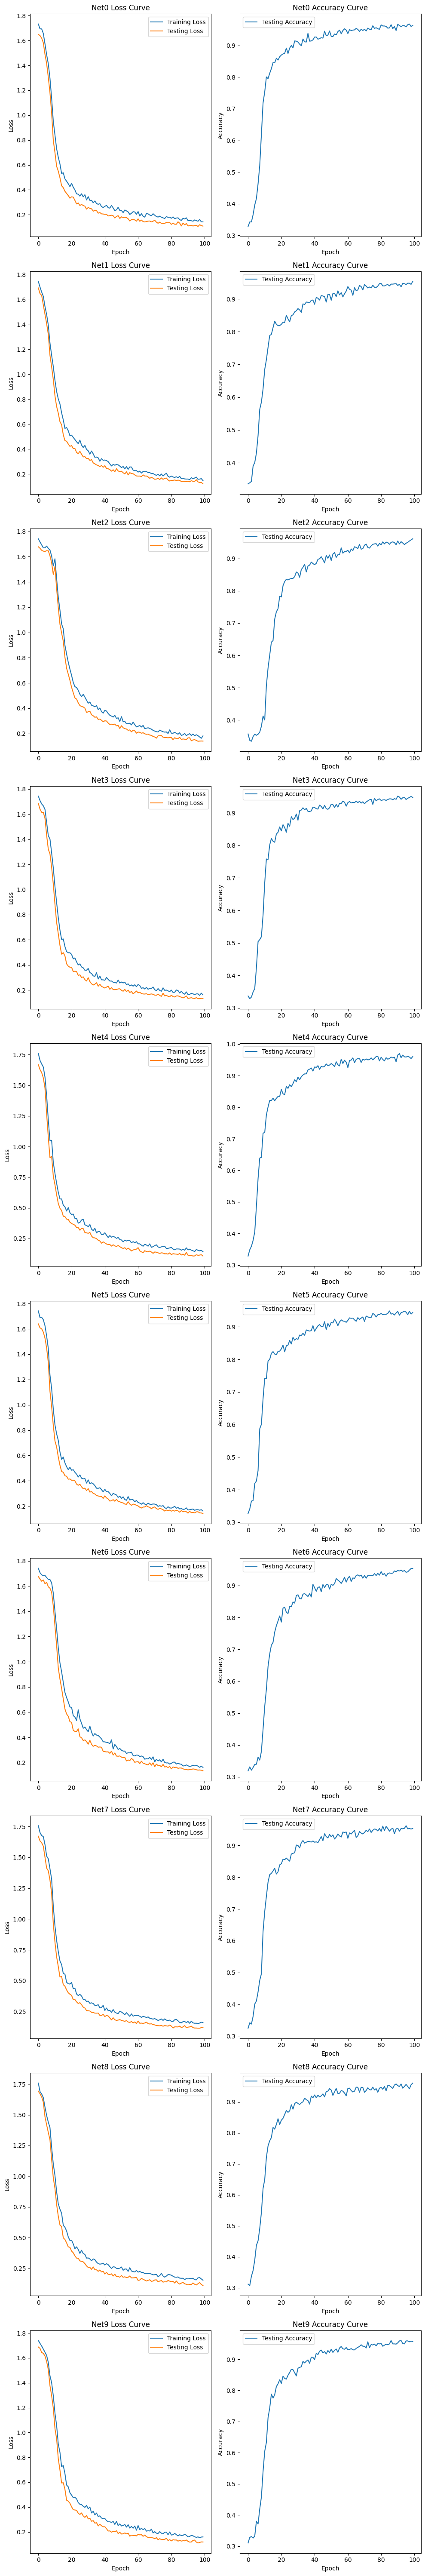

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
loss_train_final=[]
loss_test_final=[]
acc_test_final=[]


# Assuming you have the training and testing loss/accuracy values for each of the 22 networks stored in a dictionary called "results"
fig, axs = plt.subplots(10, 2, figsize=(10, 60))

for f in range(10):
    record=np.load("./ten_fold/arousal_"+str(f)+".npy")
    if f==0:
        print(record[0,:])
    train_loss = record[:,0]
    loss_train_final.append(train_loss[99])
    test_loss = record[:,1]
    loss_test_final.append(test_loss[99])
    test_acc = record[:,2]
    acc_test_final.append(test_acc[99])
    # Plot the training and testing loss curves for this network
    axs[f, 0].plot(train_loss, label="Training Loss")
    axs[f, 0].plot(test_loss, label="Testing Loss")
    axs[f, 0].set_title(f"Net{int(f)} Loss Curve")
    axs[f, 0].set_xlabel("Epoch")
    axs[f, 0].set_ylabel("Loss")
    axs[f, 0].legend()
    
    # Plot the training and testing accuracy curves for this network
    axs[f, 1].plot(test_acc, label="Testing Accuracy")
    axs[f, 1].set_title(f"Net{int(f)} Accuracy Curve")
    axs[f, 1].set_xlabel("Epoch")
    axs[f, 1].set_ylabel("Accuracy")
    axs[f, 1].legend()

plt.tight_layout()
plt.show()

The average accuracy of 10 network is  0.9554109573364258
The average MAX of 10 network is  0.9630137085914612
The average MIN of 10 network is  0.9438356161117554


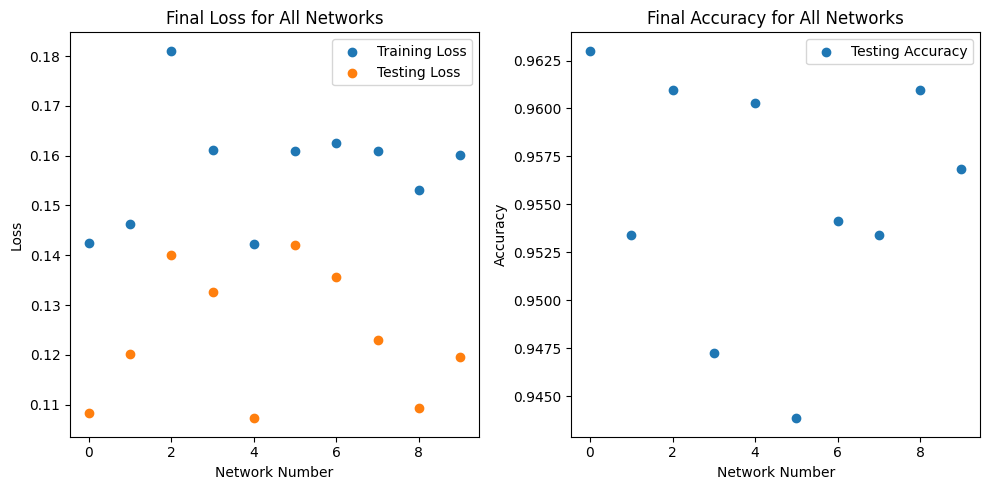

In [24]:
train_loss = loss_train_final
test_loss = loss_test_final
test_acc = acc_test_final
import matplotlib.pyplot as plt

print("The average accuracy of 10 network is ",np.average(test_acc))
print("The average MAX of 10 network is ",np.max(test_acc))
print("The average MIN of 10 network is ",np.min(test_acc))
    
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
x=[0,1,2,3,4,5,6,7,8,9]

# Plot the final training and testing loss for all networks
axs[0].scatter(x, train_loss, label="Training Loss")
axs[0].scatter(x, test_loss, label="Testing Loss")
axs[0].set_title("Final Loss for All Networks")
axs[0].set_xlabel("Network Number")
axs[0].set_ylabel("Loss")
axs[0].legend()

# Plot the final training and testing accuracy for all networks
axs[1].scatter(x, test_acc, label="Testing Accuracy")
axs[1].set_title("Final Accuracy for All Networks")
axs[1].set_xlabel("Network Number")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

**VELENCE RESULTS**

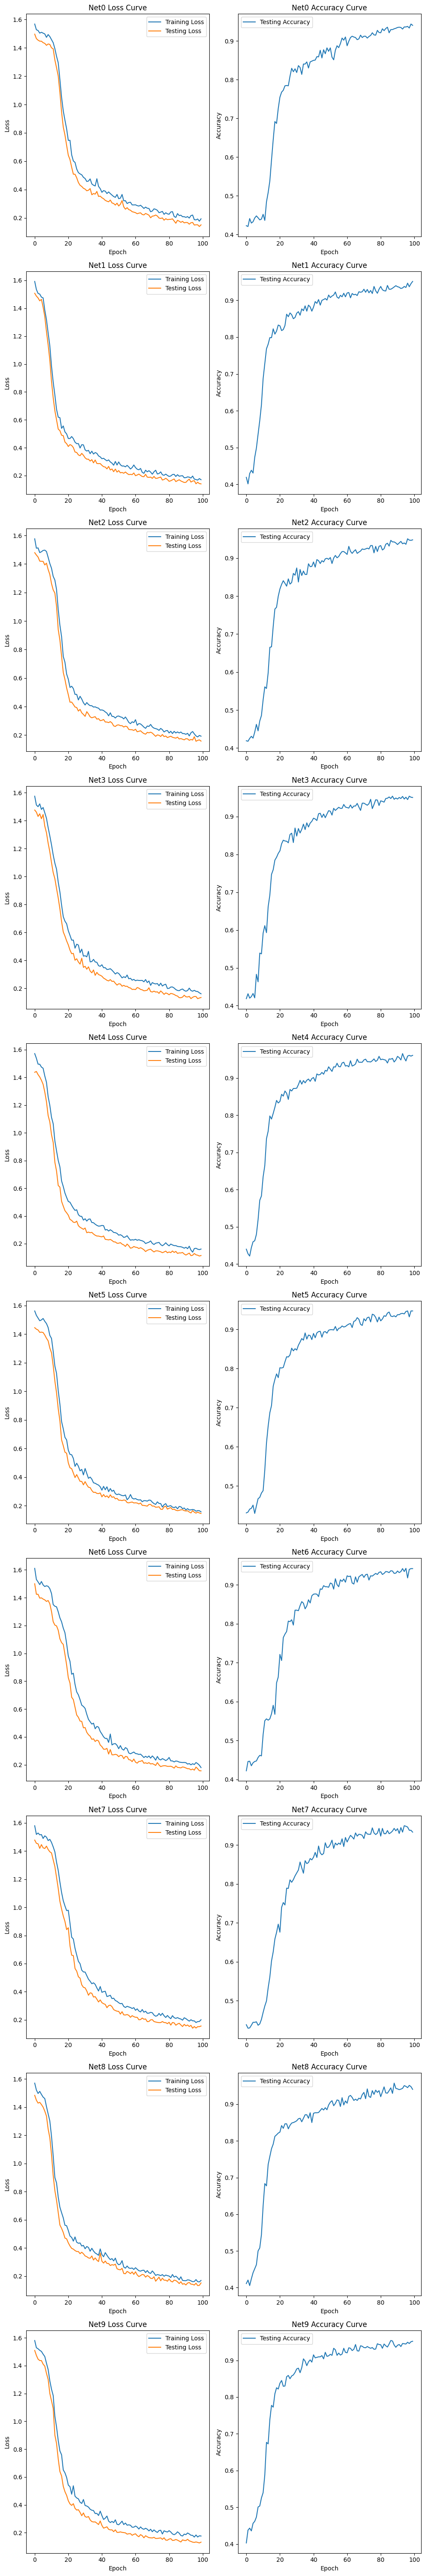

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
loss_train_final=[]
loss_test_final=[]
acc_test_final=[]


# Assuming you have the training and testing loss/accuracy values for each of the 22 networks stored in a dictionary called "results"
fig, axs = plt.subplots(10, 2, figsize=(10, 60))

for f in range(10):
    record=np.load("./ten_fold/valence_"+str(f)+".npy")
    train_loss = record[:,0]
    loss_train_final.append(train_loss[99])
    test_loss = record[:,1]
    loss_test_final.append(test_loss[99])
    test_acc = record[:,2]
    acc_test_final.append(test_acc[99])
    # Plot the training and testing loss curves for this network
    axs[f, 0].plot(train_loss, label="Training Loss")
    axs[f, 0].plot(test_loss, label="Testing Loss")
    axs[f, 0].set_title(f"Net{int(f)} Loss Curve")
    axs[f, 0].set_xlabel("Epoch")
    axs[f, 0].set_ylabel("Loss")
    axs[f, 0].legend()
    
    # Plot the training and testing accuracy curves for this network
    axs[f, 1].plot(test_acc, label="Testing Accuracy")
    axs[f, 1].set_title(f"Net{int(f)} Accuracy Curve")
    axs[f, 1].set_xlabel("Epoch")
    axs[f, 1].set_ylabel("Accuracy")
    axs[f, 1].legend()

plt.tight_layout()
plt.show()

The average accuracy of 10 network is  0.9465753376483917
The average MAX of 10 network is  0.9609588980674744
The average MIN of 10 network is  0.932876706123352


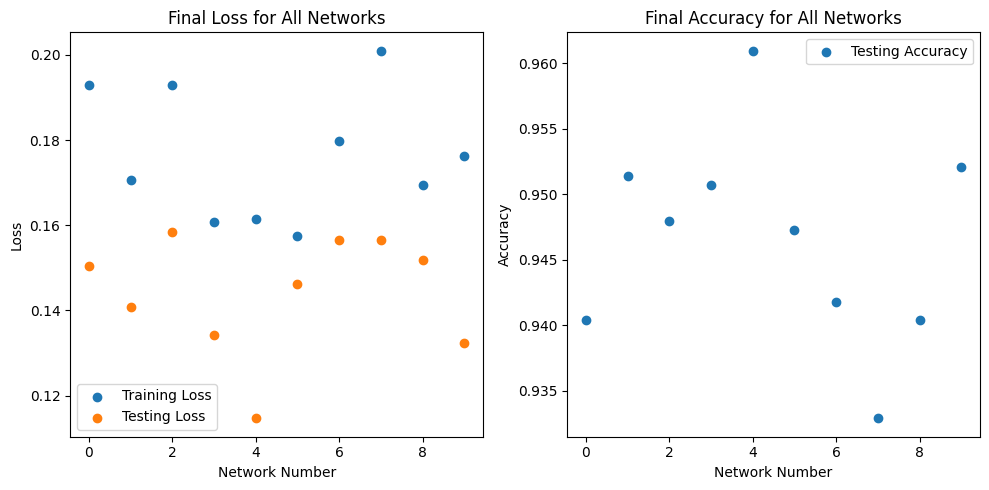

In [20]:
train_loss = loss_train_final
test_loss = loss_test_final
test_acc = acc_test_final
import matplotlib.pyplot as plt

print("The average accuracy of 10 network is ",np.average(test_acc))
print("The average MAX of 10 network is ",np.max(test_acc))
print("The average MIN of 10 network is ",np.min(test_acc))
    
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
x=[0,1,2,3,4,5,6,7,8,9]

# Plot the final training and testing loss for all networks
axs[0].scatter(x, train_loss, label="Training Loss")
axs[0].scatter(x, test_loss, label="Testing Loss")
axs[0].set_title("Final Loss for All Networks")
axs[0].set_xlabel("Network Number")
axs[0].set_ylabel("Loss")
axs[0].legend()

# Plot the final training and testing accuracy for all networks
axs[1].scatter(x, test_acc, label="Testing Accuracy")
axs[1].set_title("Final Accuracy for All Networks")
axs[1].set_xlabel("Network Number")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()